In [1]:
!pip install segmentation-models
!pip install tensorflow==2.1.0
!pip install keras==2.3.1

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import cv2
import keras
import numpy as np
import matplotlib.pyplot as plt
import segmentation_models as sm
from datetime import datetime

Using TensorFlow backend.


Segmentation Models: using `keras` framework.


In [3]:
!unzip sky
DATA_DIR = './sky/'
# load repo with data if it is not exists
if not os.path.exists(DATA_DIR):
 print('Please, upload the data!')

Archive:  sky.zip
replace sky/test/ann/0003_gt.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [4]:
x_train_dir = os.path.join(DATA_DIR, 'train/img')
y_train_dir = os.path.join(DATA_DIR, 'train/ann')

x_test_dir = os.path.join(DATA_DIR, 'test/img')
y_test_dir = os.path.join(DATA_DIR, 'test/ann')

x_valid_dir = os.path.join(DATA_DIR, 'val/img')
y_valid_dir = os.path.join(DATA_DIR, 'val/ann')

In [5]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x

# classes for data loading and preprocessing
class Dataset:
    """CamVid Dataset. Read images, apply preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. normalization, shape manipulation, etc.)
    """
    
    CLASSES = ['sky', 'building', 'pole', 'road', 'pavement', 
               'tree', 'signsymbol', 'fence', 'car', 
               'pedestrian', 'bicyclist', 'unlabelled']

    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None,
            preprocessing=None):
      self.ids = sorted(os.listdir(images_dir))
      self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
      self.masks_fps = [os.path.join(masks_dir, image_id.replace(".png","_gt.png")) for image_id in self.ids]
      
      # convert str names to class values on masks
      #self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
      self.preprocessing = preprocessing

    def __getitem__(self, i):
      # read data
      image = cv2.imread(self.images_fps[i])
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      image=cv2.resize(image,(128,128))
      mask = cv2.imread(self.masks_fps[i], 0)

      # extract certain classes from mask (e.g. cars)
      mask=cv2.resize(mask,(128,128))
      ret, mask = cv2.threshold(mask, 127, 1, cv2.THRESH_BINARY)
      mask=mask.astype('int')
      mask= np.expand_dims(mask, axis=2)
      
      # apply preprocessing
      if self.preprocessing:
          image = self.preprocessing(image)
          
      return image, mask

    def __len__(self):
      return len(self.ids)

class Dataloder(keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
      self.dataset = dataset
      self.batch_size = batch_size
      self.shuffle = shuffle
      self.indexes = np.arange(len(dataset))

      self.on_epoch_end()

    def __getitem__(self, i):
      # collect batch data
      start = i * self.batch_size
      stop = (i + 1) * self.batch_size
      data = []
      for j in range(start, stop):
          data.append(self.dataset[j])        
      # transpose list of lists
      batch = [np.stack(samples, axis=0) for samples in zip(*data)]
      
      return batch

    def __len__(self):
      """Denotes the number of batches per epoch"""
      return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
      """Callback function to shuffle indexes each epoch"""
      if self.shuffle:
          self.indexes = np.random.permutation(self.indexes)

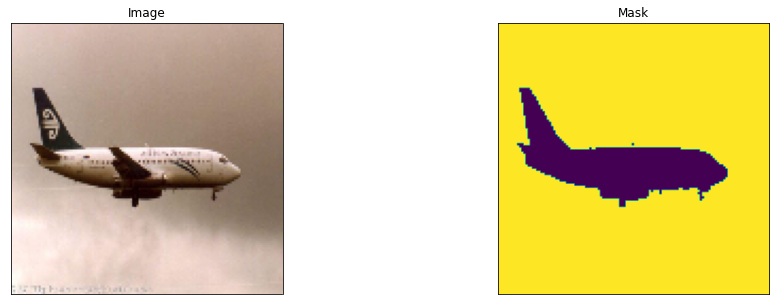

In [6]:
# Lets look at data we have
dataset = Dataset(x_train_dir, y_train_dir)

image, mask = dataset[2] # get some sample

visualize(
 image=image, 
 mask=mask[..., 0].squeeze()
)

In [7]:
BACKBONE = 'efficientnetb3'
BATCH_SIZE = 10
LR = 0.0001
EPOCHS = 50

preprocess_input = sm.get_preprocessing(BACKBONE)
print(preprocess_input)

<function preprocess_input at 0x7f4f67f00830>


In [8]:
# define network parameters
n_classes = 1
activation = 'sigmoid'

#create model
model = sm.Linknet(BACKBONE, classes=n_classes, activation=activation)

# define optomizer
optim = keras.optimizers.Adam(LR)
# compile keras model with defined optimozer, loss and metrics
model.compile(optim,loss=sm.losses.bce_jaccard_loss, metrics=[sm.metrics.iou_score])

In [9]:
# Dataset for train images
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir,
    preprocessing=preprocess_input,
)


# Dataset for validation images
valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir,
    preprocessing=preprocess_input,
)


#print(train_dataloader[0][1].shape)
train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloder(valid_dataset, batch_size=1, shuffle=False)
# check shapes for errors
assert train_dataloader[0][0].shape == (BATCH_SIZE, 128,128, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, 128,128,  n_classes)

In [10]:
start = datetime.now() 

# train model
history = model.fit_generator(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=EPOCHS,
    verbose=1,
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader)
)

stop = datetime.now() 
execution_time = stop-start

Epoch 1/50
4/4 [==============================] - 56s 14s/step - loss: 1.2581 - iou_score: 0.3579 - val_loss: 2.4481 - val_iou_score: 0.0512
Epoch 2/50
4/4 [==============================] - 17s 4s/step - loss: 1.2097 - iou_score: 0.3751 - val_loss: 2.2500 - val_iou_score: 0.0698
Epoch 3/50
4/4 [==============================] - 16s 4s/step - loss: 1.1603 - iou_score: 0.3928 - val_loss: 2.0455 - val_iou_score: 0.0977
Epoch 4/50
4/4 [==============================] - 16s 4s/step - loss: 1.1172 - iou_score: 0.4091 - val_loss: 1.8890 - val_iou_score: 0.1270
Epoch 5/50
4/4 [==============================] - 16s 4s/step - loss: 1.0741 - iou_score: 0.4259 - val_loss: 1.7456 - val_iou_score: 0.1610
Epoch 6/50
4/4 [==============================] - 16s 4s/step - loss: 1.0321 - iou_score: 0.4426 - val_loss: 1.6333 - val_iou_score: 0.1939
Epoch 7/50
4/4 [==============================] - 16s 4s/step - loss: 0.9946 - iou_score: 0.4582 - val_loss: 1.5264 - val_iou_score: 0.2299
Epoch 8/50
4/4 [===

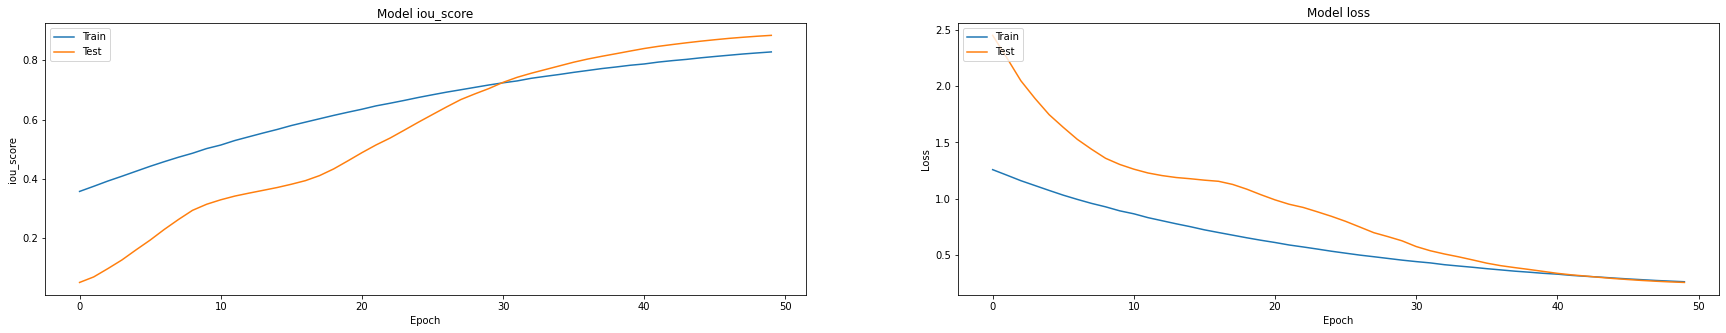

In [11]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [12]:
test_images = []
ids =  sorted(os.listdir(x_test_dir))
for image in [os.path.join(x_test_dir, image_id) for image_id in ids]:
  image = cv2.imread(image)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image=cv2.resize(image,(128,128))
  test_images.append(image)

#Convert list to array for machine learning processing        
test_images = np.array(test_images)

test_masks = []
for mask in [os.path.join(y_test_dir, image_id.replace(".png","_gt.png")) for image_id in ids]:
  mask = cv2.imread(mask,cv2.IMREAD_GRAYSCALE)
  mask=cv2.resize(mask,(128,128))
  ret, mask = cv2.threshold(mask, 127, 1, cv2.THRESH_BINARY)
  mask = np.expand_dims(mask, axis=2) 
  test_masks.append(mask)
#Convert list to array for machine learning processing          
test_masks = np.array(test_masks) 


In [13]:
X_test_feature=preprocess_input(test_images)
test_prediction = model.predict(X_test_feature).squeeze()
for i in range(len(test_prediction)):
  test_prediction[i][test_prediction[i] < 0.5] = 0
  test_prediction[i][test_prediction[i] >= 0.5] = 1

y_test = test_masks

from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(y_test.ravel(),test_prediction.ravel()))

from keras.metrics import MeanIoU
IOU_keras = MeanIoU(num_classes=2)  

IOU_keras.update_state(y_test.ravel(),test_prediction.ravel())
print ("IOU on testing data = ", IOU_keras.result().numpy())

print ("IOU for each class on testing data:")
values = np.array(IOU_keras.get_weights()).reshape(2,2)
class1_IoU = values[0,0]/(values[0,0] + values[0,1]+ values[1,0])
class2_IoU = values[1,1]/(values[1,1] + values[1,0]+ values[0,1])
print(class1_IoU)
print(class2_IoU)
print("execution time is: ", execution_time)

Accuracy =  0.94407958984375
IOU on testing data =  0.8936731
IOU for each class on testing data:
0.9002677813336817
0.8870784855058174
execution time is:  0:14:46.625174


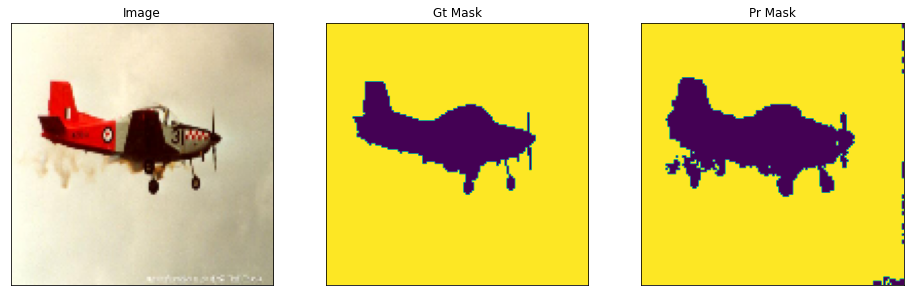

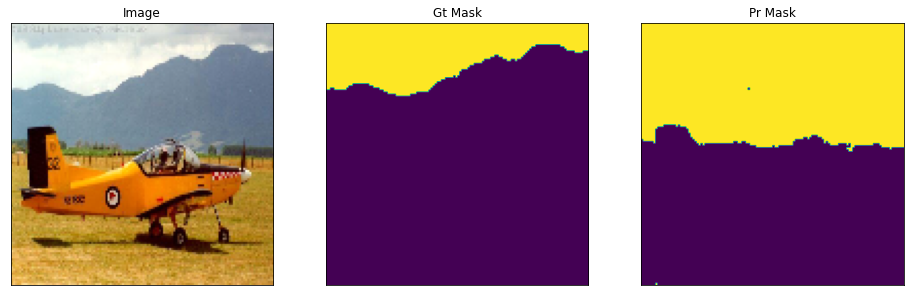

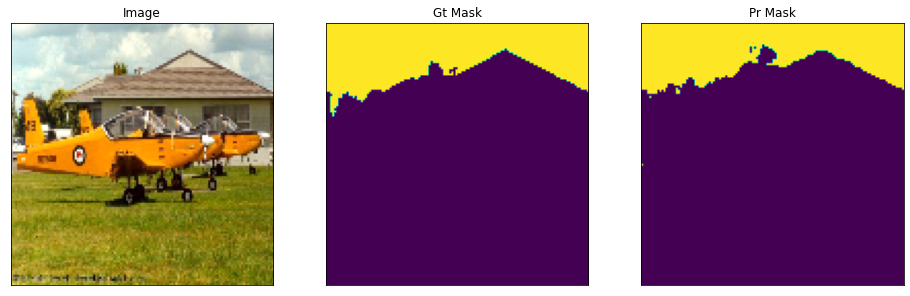

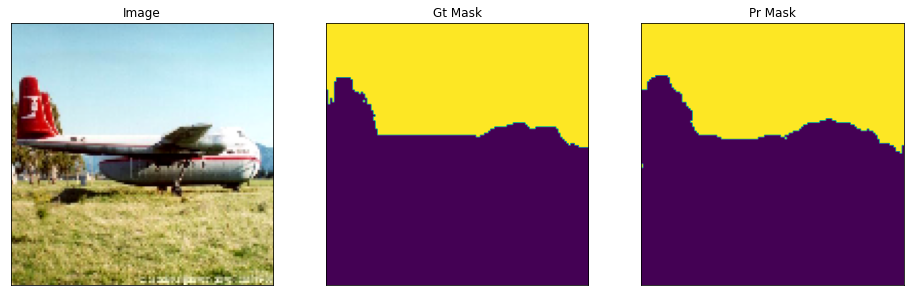

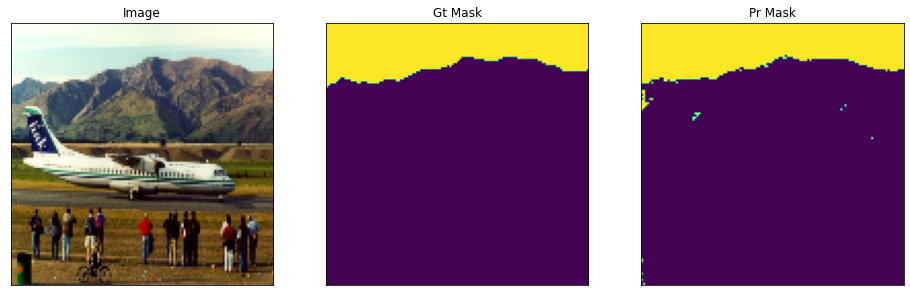

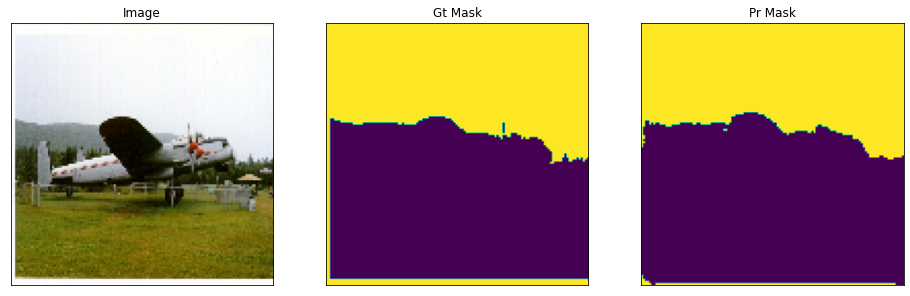

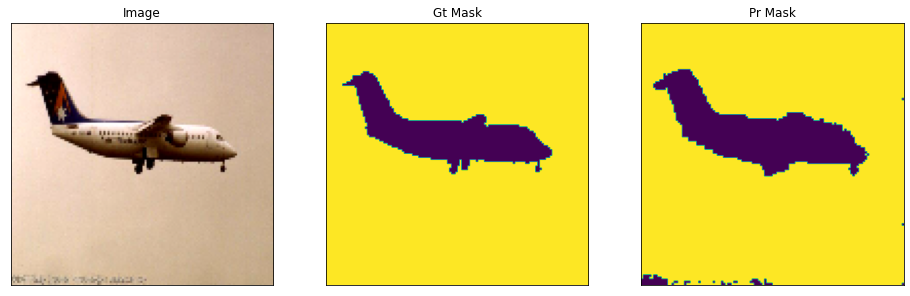

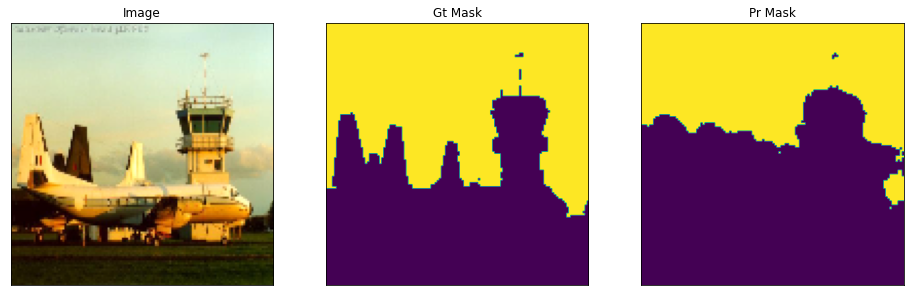

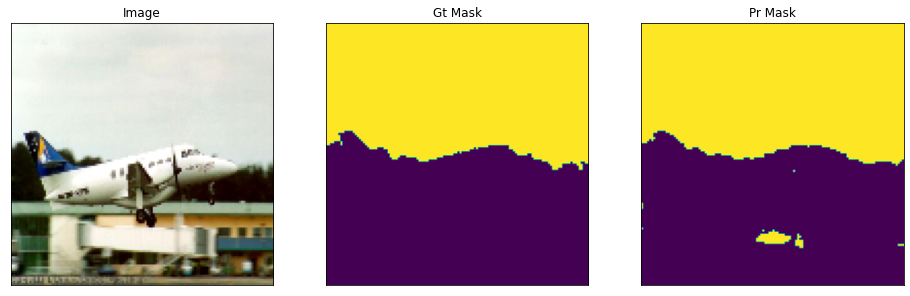

In [14]:
for i in range(0,9):
    
    image = test_images[i]
    gt_mask=test_masks[i]

    test_feature = preprocess_input(image)
    test_feature = np.expand_dims(test_feature, axis=0)

    pr_mask = model.predict(test_feature)
    pr_mask=pr_mask.squeeze()
    pr_mask[pr_mask < 0.5] = 0
    pr_mask[pr_mask >= 0.5] = 1


    visualize(
        image=denormalize(image.squeeze()),
        gt_mask=gt_mask.squeeze(),
        pr_mask=pr_mask.squeeze(),
    )

In [15]:
#Save the trained model as pickle string to disk for future use
filename = "Linknet_cars_model"
pickle.dump(model, open(filename, 'wb'))

NameError: ignored